# ITU Machine Learning Fall 2021

## Final Project: M3
## 3rd Classification Method: Naive Bayes


### Group AC
Chrisanna Cornish <ccor@itu.dk> <br>
Carl August Wismer <cwis@itu.dk><br>
Danielle Marie Dequin <ddeq@itu.dk>

Last Edited: 28/12/2021

## Imports

In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

## Paths

In [2]:
TRAIN = '../Data/df_train.csv'
TEST = '../Data/df_test.csv'

## Functions

In [3]:
# code from exercise 5 to calculate the z-score
z_score = lambda x : (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def conf_mat(y_hat, y_true):
    '''Returns a confusion matrix'''
    n = max(y_hat)+1
    bingo = np.zeros([n,n])
    for i in range(len(y_hat)):
        bingo[y_true[i]][y_hat[i]] +=1
    
    return(bingo)

def scores(y_hat, y_true, average = False):
    '''For each class, returns recall, precision and f1'''
    classes = list(np.unique(y_true))
    conf = conf_mat(y_hat, y_true)
    r = []
    p = []
    f = []
    for c in classes:
        recall = conf[c][c] / sum(conf[c])
        precision = conf[c][c] / sum(conf[:, c])
        f1 = 2*(precision*recall)/(precision + recall)
        r.append(recall)
        p.append(precision)
        f.append(f1)
    if average:
        return sum(r)/len(r), sum(p)/len(p), sum(f)/len(f)
    else:
        return (r, p, f)

In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Function copied from exercise 7.
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylim([-0.5, cm.shape[0]-0.5])

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Variables and df loading

In [10]:
col = 'rainbow' # Colour theme

df = pd.read_csv(TRAIN) # Training dataframe
print(len(df))

# ensures data is without order, random state fixed for reproducability, frac=1 gives the whole df back but shuffled
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(len(df)) # confirm still have the whole df

attributes = list(df.columns)[:-1] # Creates list of column names for the dataframe without the class

X = df[attributes].copy() # Attributes
y = df['type'].copy() # True values

y_list = y.unique() # 'y' values

df.head(3) #consider if scaling is needed...

149
149


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
0,1.52664,11.23,0.00,0.77,73.21,0.00,14.68,0.0,0.00,2
1,1.51627,13.00,3.58,1.54,72.83,0.61,8.04,0.0,0.00,2
2,1.51796,13.50,3.36,1.63,71.94,0.57,8.81,0.0,0.09,3


## Shift Y values

In [13]:
y2 = y.copy()

In [14]:
for i in range(len(y2)):
    if y2[i] > 4:
        y2[i] = y2[i] - 2
    else:
        y2[i] = y2[i] - 1

In [15]:
y2.unique(), y2.shape

(array([1, 2, 5, 3, 0, 4], dtype=int64), (149,))

## Principal Component Analysis

In [5]:
pca = PCA(n_components=9)
pca.fit(X)

X_pca = pd.DataFrame(pca.transform(X))
X_pca = z_score(X_pca)

print(pca.explained_variance_ratio_, '\n')
pca_exp = pca.explained_variance_ratio_
s = 0
c = 1
for i in pca_exp:
    s += i
    print(f'{c} components explain {round(100*s,2)}% of the data')
    c+=1

[4.83486194e-01 2.71921761e-01 1.05595720e-01 8.90614729e-02
 3.19451847e-02 1.63912126e-02 1.36991204e-03 2.28386128e-04
 1.55805904e-07] 

1 components explain 48.35% of the data
2 components explain 75.54% of the data
3 components explain 86.1% of the data
4 components explain 95.01% of the data
5 components explain 98.2% of the data
6 components explain 99.84% of the data
7 components explain 99.98% of the data
8 components explain 100.0% of the data
9 components explain 100.0% of the data


In [6]:
pca = PCA(n_components=7) # 99% of the data explained.
pca.fit(X)

X_pca = pd.DataFrame(pca.transform(X))
X_pca = z_score(X_pca)

## Building a Model

              precision    recall  f1-score   support

           0       0.50      0.78      0.61         9
           1       0.75      0.21      0.33        14
           2       0.25      0.50      0.33         2
           3       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         4

    accuracy                           0.53        30
   macro avg       0.58      0.58      0.55        30
weighted avg       0.68      0.53      0.53        30



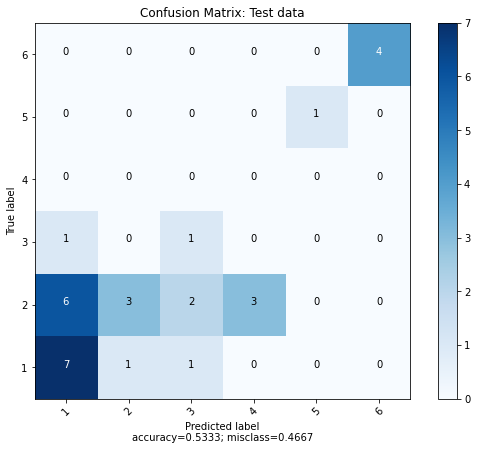

In [49]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y2, test_size=0.2, random_state=8)

# Initalize model and fit the data
gnb = GaussianNB()
gnb.fit(X_pca, y2)

# Predict the classes of the test split
pred = gnb.predict(X_test)

print(metrics.classification_report(y_test, pred))
cm = confusion_matrix(y_test, predicted);
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['1', '2', '3', '4', '5', '6'],
                      title        = "Confusion Matrix: Test data")

## K-Fold Cross Validation

In [50]:
gnb = GaussianNB()

num_folds = 5
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(X_pca, y2):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    fold_x = X_pca.iloc[train].copy().reset_index(drop=True)
    fold_y = y2.iloc[train].copy().reset_index(drop=True)
    
    # Fit data to model
    clf = gnb.fit(fold_x, fold_y)
    
    # Predict the test data
    y_pred = gnb.predict(X_pca.iloc[test])
    
    # Generate Metrics
    loss = round(log_loss(y2.iloc[test], gnb.predict_proba(X_pca.iloc[test]), eps=1e-15, labels=[0,1,2,3,4,5]),2)
    accuracy = round((y_pred==y2.iloc[test]).mean(),2)
    print(f'Score for fold {fold_no}: Loss of {loss}; Accuracy of {accuracy*100}%')

    target_names = ['class {}'.format(i+1) for i in range(6)]
    #print(classification_report(y2.iloc[test], y_pred, target_names=target_names, zero_division=0, labels=[0,1,2,3,4,5]))
    
    acc_per_fold.append(accuracy * 100)
    loss_per_fold.append(loss)

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: Loss of 3.8; Accuracy of 56.99999999999999%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: Loss of 2.55; Accuracy of 47.0%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: Loss of 1.36; Accuracy of 56.99999999999999%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: Loss of 1.21; Accuracy of 60.0%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: Loss of 2.42; Accuracy of 34.0%


In [46]:
print(f'Average Accuracy: {round(sum(acc_per_fold)/len(acc_per_fold),3)}%')

Average Accuracy: 49.8%


In [48]:
print(f'Average Loss: {round(sum(loss_per_fold)/len(loss_per_fold),2)}')

Average Loss: 2.45


## Running the Test Data Through